In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np


import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1
factor = 4 # 8
enforse_div32 = 'CROP'
PLOT = True

from PIL import Image
import numpy as np


In [2]:
import torch
import torch.nn as nn
import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
import numpy as np

import matplotlib.pyplot as plt

def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d,
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2),
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.

    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []

    for opt in opt_over_list:

        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'

    return params

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)

    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid

    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"

    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)

    plt.figure(figsize=(len(images_np) + factor, 12 + factor))

    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)

    plt.show()

    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size.

    Args:
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np



def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_()
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`)
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler.
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)

        fill_noise(net_input, noise_type)
        net_input *= var
    else:
        assert False

    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.

    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np):
    '''Converts image in np.array format to PIL image.

    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    if optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)

        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

In [3]:
def put_in_center(img_np, target_size):
    img_out = np.zeros([3, target_size[0], target_size[1]])

    bbox = [
            int((target_size[0] - img_np.shape[1]) / 2),
            int((target_size[1] - img_np.shape[2]) / 2),
            int((target_size[0] + img_np.shape[1]) / 2),
            int((target_size[1] + img_np.shape[2]) / 2),
    ]

    img_out[:, bbox[0]:bbox[2], bbox[1]:bbox[3]] = img_np

    return img_out


def load_LR_HR_imgs_sr(fname, imsize, factor, enforse_div32=None):
    '''Loads an image, resizes it, center crops and downscales.

    Args:
        fname: path to the image
        imsize: new size for the image, -1 for no resizing
        factor: downscaling factor
        enforse_div32: if 'CROP' center crops an image, so that its dimensions are divisible by 32.
    '''
    img_orig_pil, img_orig_np = get_image(fname, -1)

    if imsize != -1:
        img_orig_pil, img_orig_np = get_image(fname, imsize)

    # For comparison with GT
    if enforse_div32 == 'CROP':
        new_size = (img_orig_pil.size[0] - img_orig_pil.size[0] % 32,
                    img_orig_pil.size[1] - img_orig_pil.size[1] % 32)

        bbox = [
                (img_orig_pil.size[0] - new_size[0])/2,
                (img_orig_pil.size[1] - new_size[1])/2,
                (img_orig_pil.size[0] + new_size[0])/2,
                (img_orig_pil.size[1] + new_size[1])/2,
        ]

        img_HR_pil = img_orig_pil.crop(bbox)
        img_HR_np = pil_to_np(img_HR_pil)
    else:
        img_HR_pil, img_HR_np = img_orig_pil, img_orig_np

    LR_size = [
               img_HR_pil.size[0] // factor,
               img_HR_pil.size[1] // factor
    ]

    img_LR_pil = img_HR_pil.resize(LR_size, Image.Resampling.LANCZOS)
    img_LR_np = pil_to_np(img_LR_pil)

    print('HR and LR resolutions: %s, %s' % (str(img_HR_pil.size), str (img_LR_pil.size)))

    return {
                'orig_pil': img_orig_pil,
                'orig_np':  img_orig_np,
                'LR_pil':  img_LR_pil,
                'LR_np': img_LR_np,
                'HR_pil':  img_HR_pil,
                'HR_np': img_HR_np
           }


def get_baselines(img_LR_pil, img_HR_pil):
    '''Gets `bicubic`, sharpened bicubic and `nearest` baselines.'''
    img_bicubic_pil = img_LR_pil.resize(img_HR_pil.size, Image.BICUBIC)
    img_bicubic_np = pil_to_np(img_bicubic_pil)

    img_nearest_pil = img_LR_pil.resize(img_HR_pil.size, Image.NEAREST)
    img_nearest_np = pil_to_np(img_nearest_pil)

    img_bic_sharp_pil = img_bicubic_pil.filter(PIL.ImageFilter.UnsharpMask())
    img_bic_sharp_np = pil_to_np(img_bic_sharp_pil)

    return img_bicubic_np, img_bic_sharp_np, img_nearest_np



def tv_loss(x, beta = 0.5):
    '''Calculates TV loss for an image `x`.

    Args:
        x: image, torch.Variable of torch.Tensor
        beta: See https://arxiv.org/abs/1412.0035 (fig. 2) to see effect of `beta`
    '''
    dh = torch.pow(x[:,:,:,1:] - x[:,:,:,:-1], 2)
    dw = torch.pow(x[:,:,1:,:] - x[:,:,:-1,:], 2)

    return torch.sum(torch.pow(dh[:, :, :-1] + dw[:, :, :, :-1], beta))


In [4]:
import torch
import torch.nn as nn

def skip(
        num_input_channels=2, num_output_channels=3,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down)

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales

    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)

        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))

        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

In [5]:
import torch.nn as nn

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):

    if NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11,
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)
    else:
        assert False

    return net

In [6]:
import numpy as np
import torch
import torch.nn as nn

class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()

        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'


        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)

        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1:
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)

            self.padding = nn.ReplicationPad2d(pad)

        self.preserve_size = preserve_size

    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)

def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']

    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box':
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])


    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)

    elif kernel_type == 'gauss':
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'

        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos':
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):

                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor
                    dj = abs(j + 0.5 - center) / factor
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor


                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)

                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)

                kernel[i - 1][j - 1] = val


    else:
        assert False, 'wrong method name'

    kernel /= kernel.sum()

    return kernel

In [7]:
import torch
import torch.nn as nn
import numpy as np

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)

torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs:
                diff2 = (inp.size(2) - target_shape2) // 2
                diff3 = (inp.size(3) - target_shape3) // 2
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)


class GenNoise(nn.Module):
    def __init__(self, dim2):
        super(GenNoise, self).__init__()
        self.dim2 = dim2

    def forward(self, input):
        a = list(input.size())
        a[1] = self.dim2
        # print (input.data.type())

        b = torch.zeros(a).type_as(input.data)
        b.normal_()

        x = torch.autograd.Variable(b)

        return x


class Swish(nn.Module):

    def __init__(self):
        super(Swish, self).__init__()
        self.s = nn.Sigmoid()

    def forward(self, x):
        return x * self.s(x)


def act(act_fun = 'LeakyReLU'):
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0

    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

# Load image and baselines

In [8]:
imgs = load_LR_HR_imgs_sr('/content/shaky.tif', imsize, factor, enforse_div32)

HR and LR resolutions: (896, 1184), (224, 296)


In [9]:
input_depth = 32

INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

num_iter = 2000


In [10]:
net = get_net(input_depth, 'skip' , pad,
              skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

In [11]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())


2.5.1+cu121
True


### Histogram Based **Thresholding**

#Manual Entry

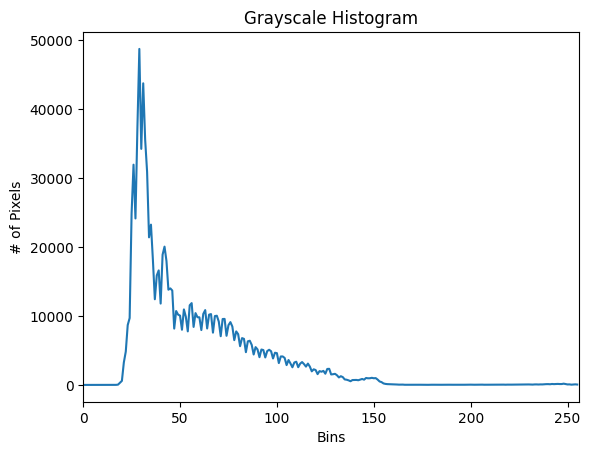

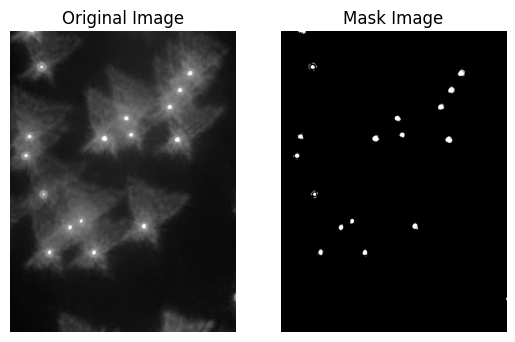

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def compute_histogram(image_path):
    # Load image in grayscale mode
    image = cv2.imread(image_path, 0)

    # Compute histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Display histogram
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(hist)
    plt.xlim([0, 256])
    plt.show()

    return image, hist

def apply_threshold(image, threshold):
    # Apply a threshold
    _, mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    # Display images
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask Image")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

    return mask

# Path to your image
image_path = '/content/shaky.tif'

# Compute histogram and load image
image, hist = compute_histogram(image_path)

# Choose a threshold value based on histogram analysis
threshold_value = 153  # Manual entry

# Apply threshold to create mask
mask = apply_threshold(image, threshold_value)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


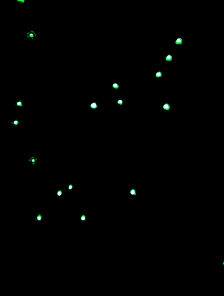

In [21]:
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
from IPython.display import display

def multiply_images_torch(image_path1, image_path2):
    # Load images
    img1 = imgs['LR_pil']
    img2 = Image.fromarray(image_path2).convert('RGB')
    img3 = imgs['HR_pil']

    # Resize image2 to image1's size if they differ
    if img1.size != img2.size:
        img2 = img2.resize(img1.size, Image.BICUBIC)

    # Convert images to tensors
    tensor1 = ToTensor()(img1)
    tensor2 = ToTensor()(img2)

    # Weight the images
    tensor1 *= 1
    tensor2 *= 1

    # Add weighted images, ensuring the result is clamped between 0 and 1 to remain a valid image
    result_tensor = torch.clamp(tensor1 + tensor2, min=0, max=1)

    # Multiply images
    result_tensor = tensor1 * tensor2

    # Convert tensor to PIL Image
    result_image = ToPILImage()(result_tensor)
    result_image.show()
    return result_image, result_tensor

result_image,result_tensor = multiply_images_torch(imgs['LR_pil'], (mask))
display(result_image)
# result_image.save('/path/to/output.jpg')
result_tensor = result_tensor.to(device)


In [22]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image

# Increase the maximum number of pixels
Image.MAX_IMAGE_PIXELS = None  # This removes the limit entirely, use with caution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)


# Load the image
image = Image.open('/content/shaky.tif').convert("L")  # Convert to grayscale if necessary

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((1184, 896)),  # Resize the image
    transforms.ToTensor()            # Convert the image to a tensor for the given model
])

# Apply the transformation
image_tensor = transform(image)
image_tensor = image_tensor.to(device)
# Since the required shape is [1, 32, 1184, 896], repeat the image across a new dimension and adjust the batch dimension
image_tensor = image_tensor.unsqueeze(0)  # Add a batch dimension [1, 1, 1184, 896]
image_tensor = image_tensor.repeat(1, 32, 1, 1)  # Repeat the image to simulate 32 channels [1, 32, 1184, 896]

# Check the shape
print("Shape of the tensor:", image_tensor.shape)

Shape of the tensor: torch.Size([1, 32, 1184, 896])


In [23]:
import math

def psnr(target, output, max_pixel=1.0):
    mse = torch.mean((target - output) ** 2)
    if mse == 0:
        return float('inf')  # Infinite PSNR means no error.
    return 20 * math.log10(max_pixel / math.sqrt(mse))

def save_final_image(tensor, file_name="/content/final_image.png"):
    # Convert the tensor to a NumPy array
    np_image = torch_to_np(tensor)

    # Clip values to ensure they are within [0, 1]
    np_image = np.clip(np_image, 0, 1)

    # Convert from (C, H, W) to (H, W, C) if necessary
    if np_image.shape[0] == 3:
        np_image = np.transpose(np_image, (1, 2, 0))

    # Convert to an image and save
    im = Image.fromarray((np_image * 255).astype(np.uint8))
    im.save(file_name)
    print(f"Image saved as {file_name}")


def closure():
    global i, output_tensor

    out_HR = net(image_tensor)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, result_tensor)

    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()

    # Log
    psnr_log = psnr(result_tensor, out_LR)

    # History
    psnr_history.append((i,psnr_log))

    if PLOT and i % 1 == 0:
        out_HR_np = torch_to_np(out_HR)
        if i % 100 == 0:
            plot_image_grid([imgs['HR_np'], np.clip(out_HR_np, 0, 1)], factor=5, nrow=2)
        print(f"Iteration {i}: Loss {total_loss.item()} PSNR: {psnr_log} dB")

    # Save image at each iteration
    save_final_image(out_HR, f"output images/i={i}.png")

    # Increment iteration counter
    i += 1

    # Save final image after the last iteration
    if i == num_iter:
        save_final_image(out_HR, "final_output_image.png")
    return total_loss


In [24]:
psnr_history = []
i = 0
p = get_params(OPT_OVER, net, image_tensor)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([3, 296, 224])) that is different to the input size (torch.Size([1, 3, 296, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

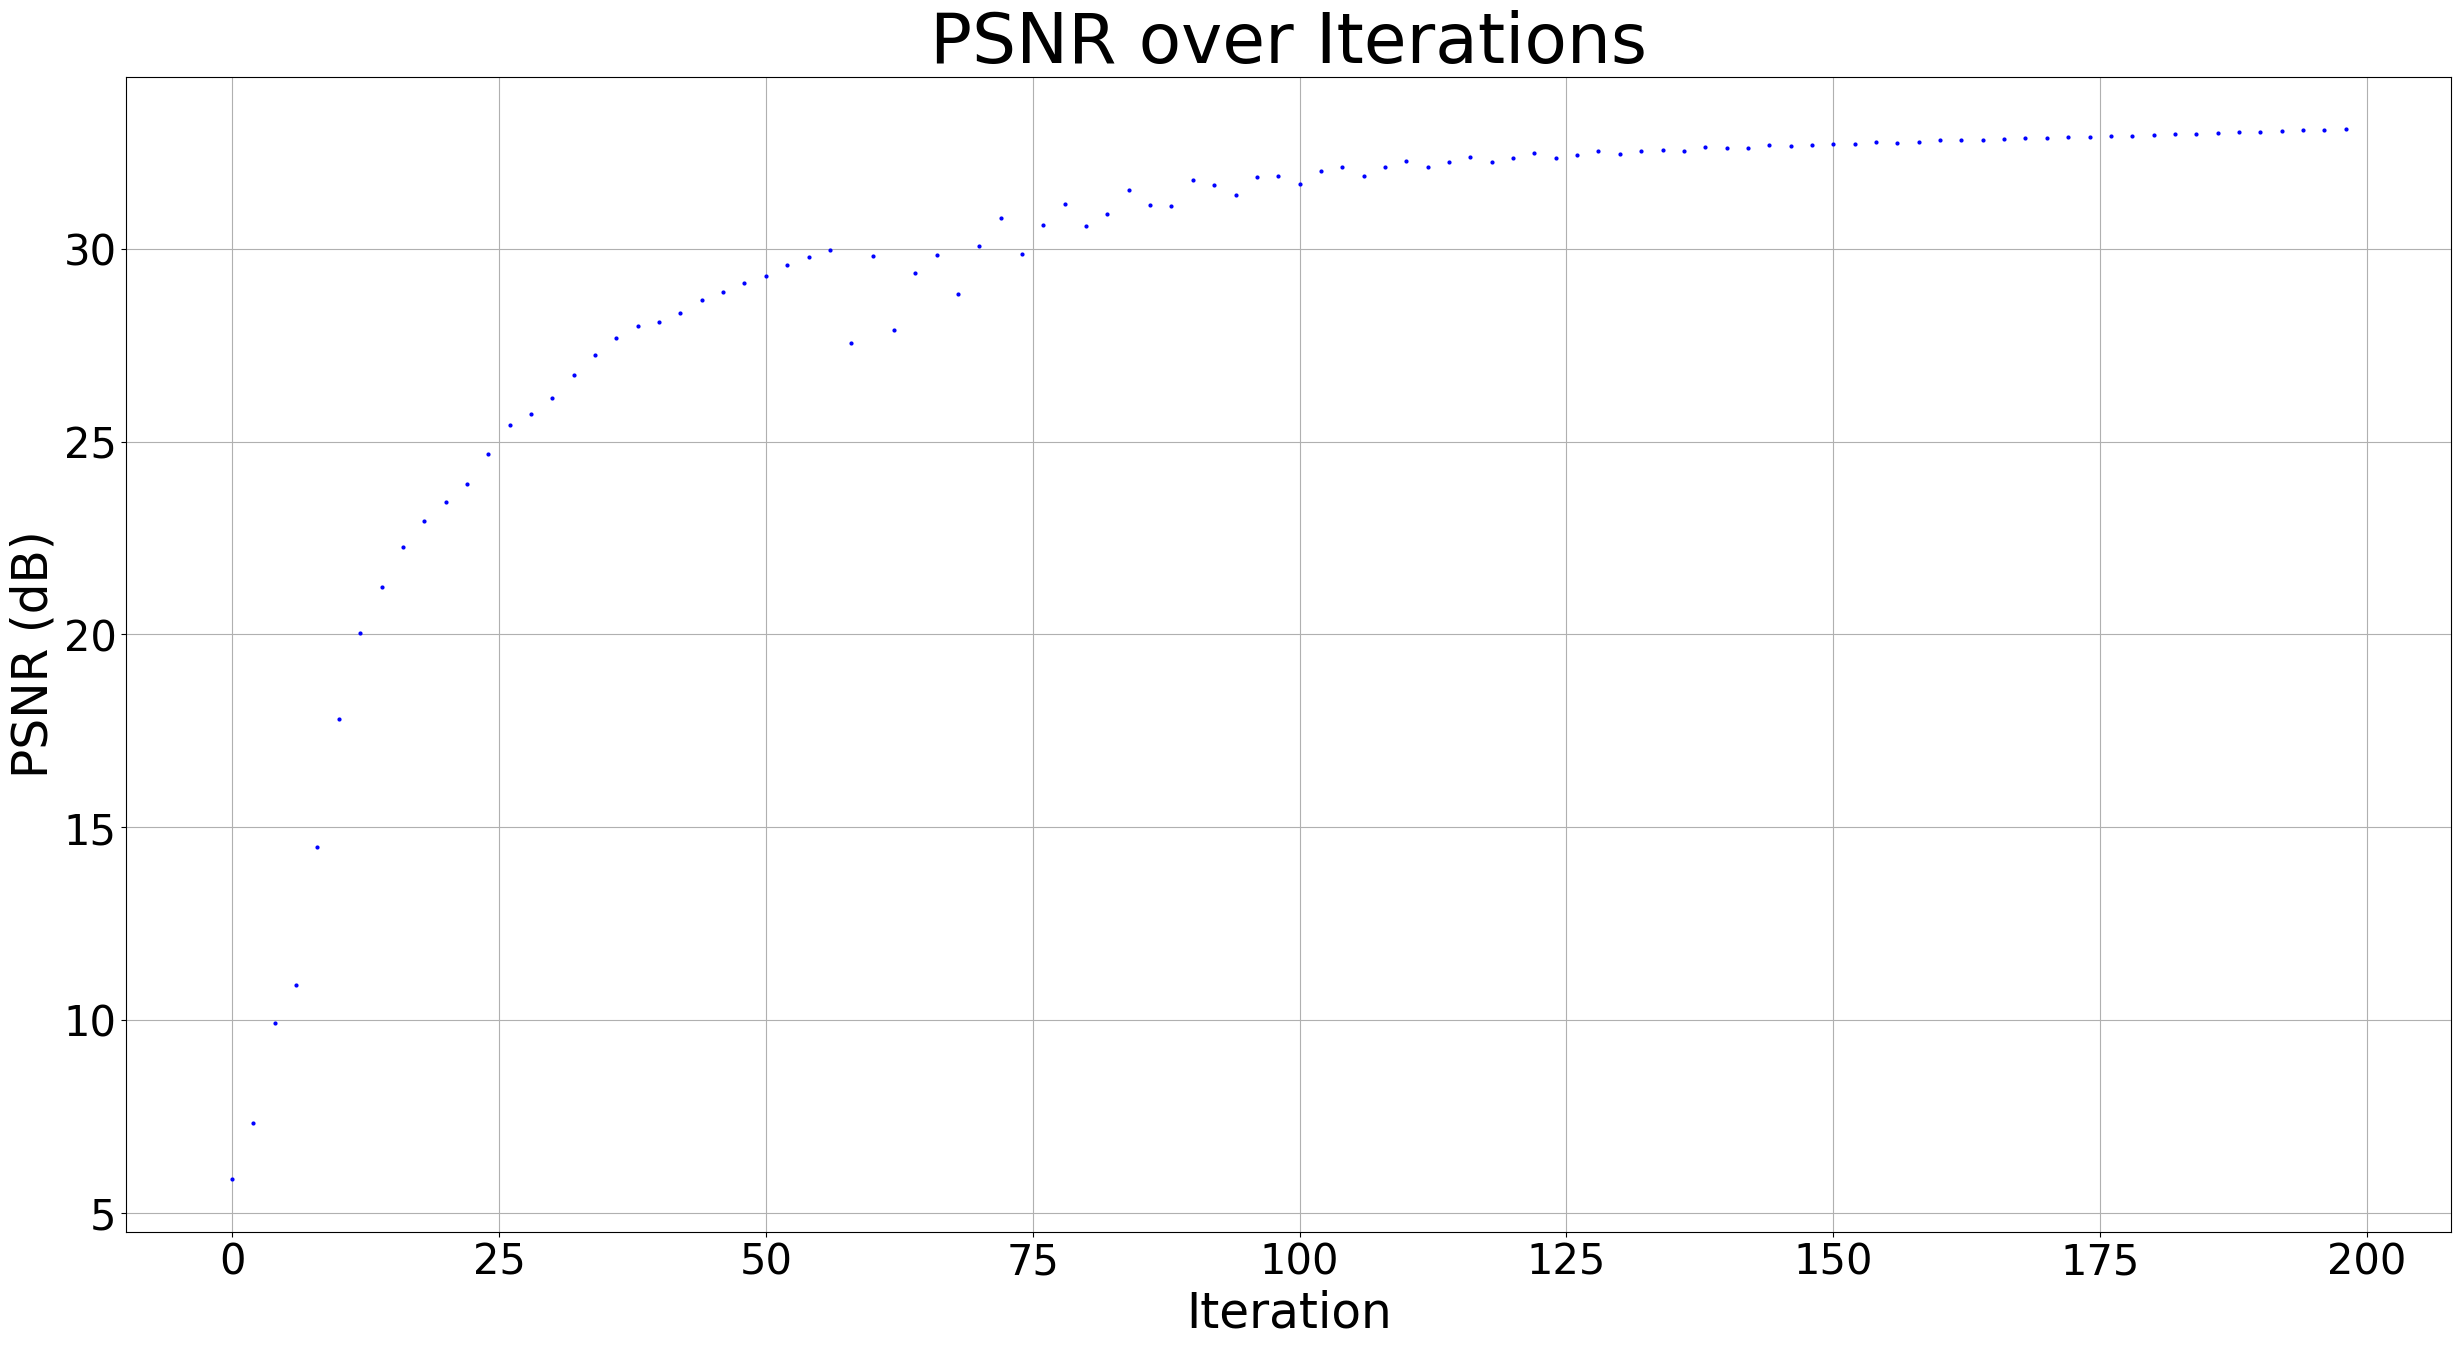

In [ ]:
# Display the results
def plot_images(hr_image, output_image):
    plt.figure(figsize=(18, 6))
    titles = ['High-Resolution', 'Output']
    images = [hr_image, output_image]
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

# out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
in_HR_np = imgs['HR_np']

# plot_images(out_HR_np, in_HR_np)

import matplotlib.pyplot as plt
# Extracting iteration numbers and PSNR values
iterations, psnrs = zip(*psnr_history)

plt.figure(figsize=(30, 15))
plt.plot(iterations, psnrs, 'bo',markersize=2,linewidth=3)
plt.title('PSNR over Iterations',fontsize=50)
plt.xlabel('Iteration',fontdict={'size':35 })
plt.ylabel('PSNR (dB)',fontdict={'size':35 })
plt.tick_params(axis='both', which='major', labelsize=30)
plt.grid(True)
plt.show()

In [ ]:
img_test = load_LR_HR_imgs_sr('/content/b.jpg', imsize, factor, enforse_div32)

HR and LR resolutions: (12000, 8992), (3000, 2248)


In [ ]:
image = Image.open('/content/b.jpg').convert("L")  # Convert to grayscale if necessary

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((1184, 896)),  # Resize the image
    transforms.ToTensor()            # Convert the image to a tensor for the given model
])

# Apply the transformation
test_new_tensor = transform(image)
test_new_tensor = test_new_tensor.to(device)
# Since the required shape is [1, 32, 1184, 896], repeat the image across a new dimension and adjust the batch dimension
test_new_tensor = test_new_tensor.unsqueeze(0)  # Add a batch dimension [1, 1, 1184, 896]
test_new_tensor = test_new_tensor.repeat(1, 32, 1, 1)
print(test_new_tensor.shape)

torch.Size([1, 32, 1184, 896])


In [ ]:
new_HR_np = np.clip(torch_to_np(net(test_new_tensor)), 0, 1)
result_deep_prior = put_in_center(new_HR_np, imgs['orig_np'].shape[1:])

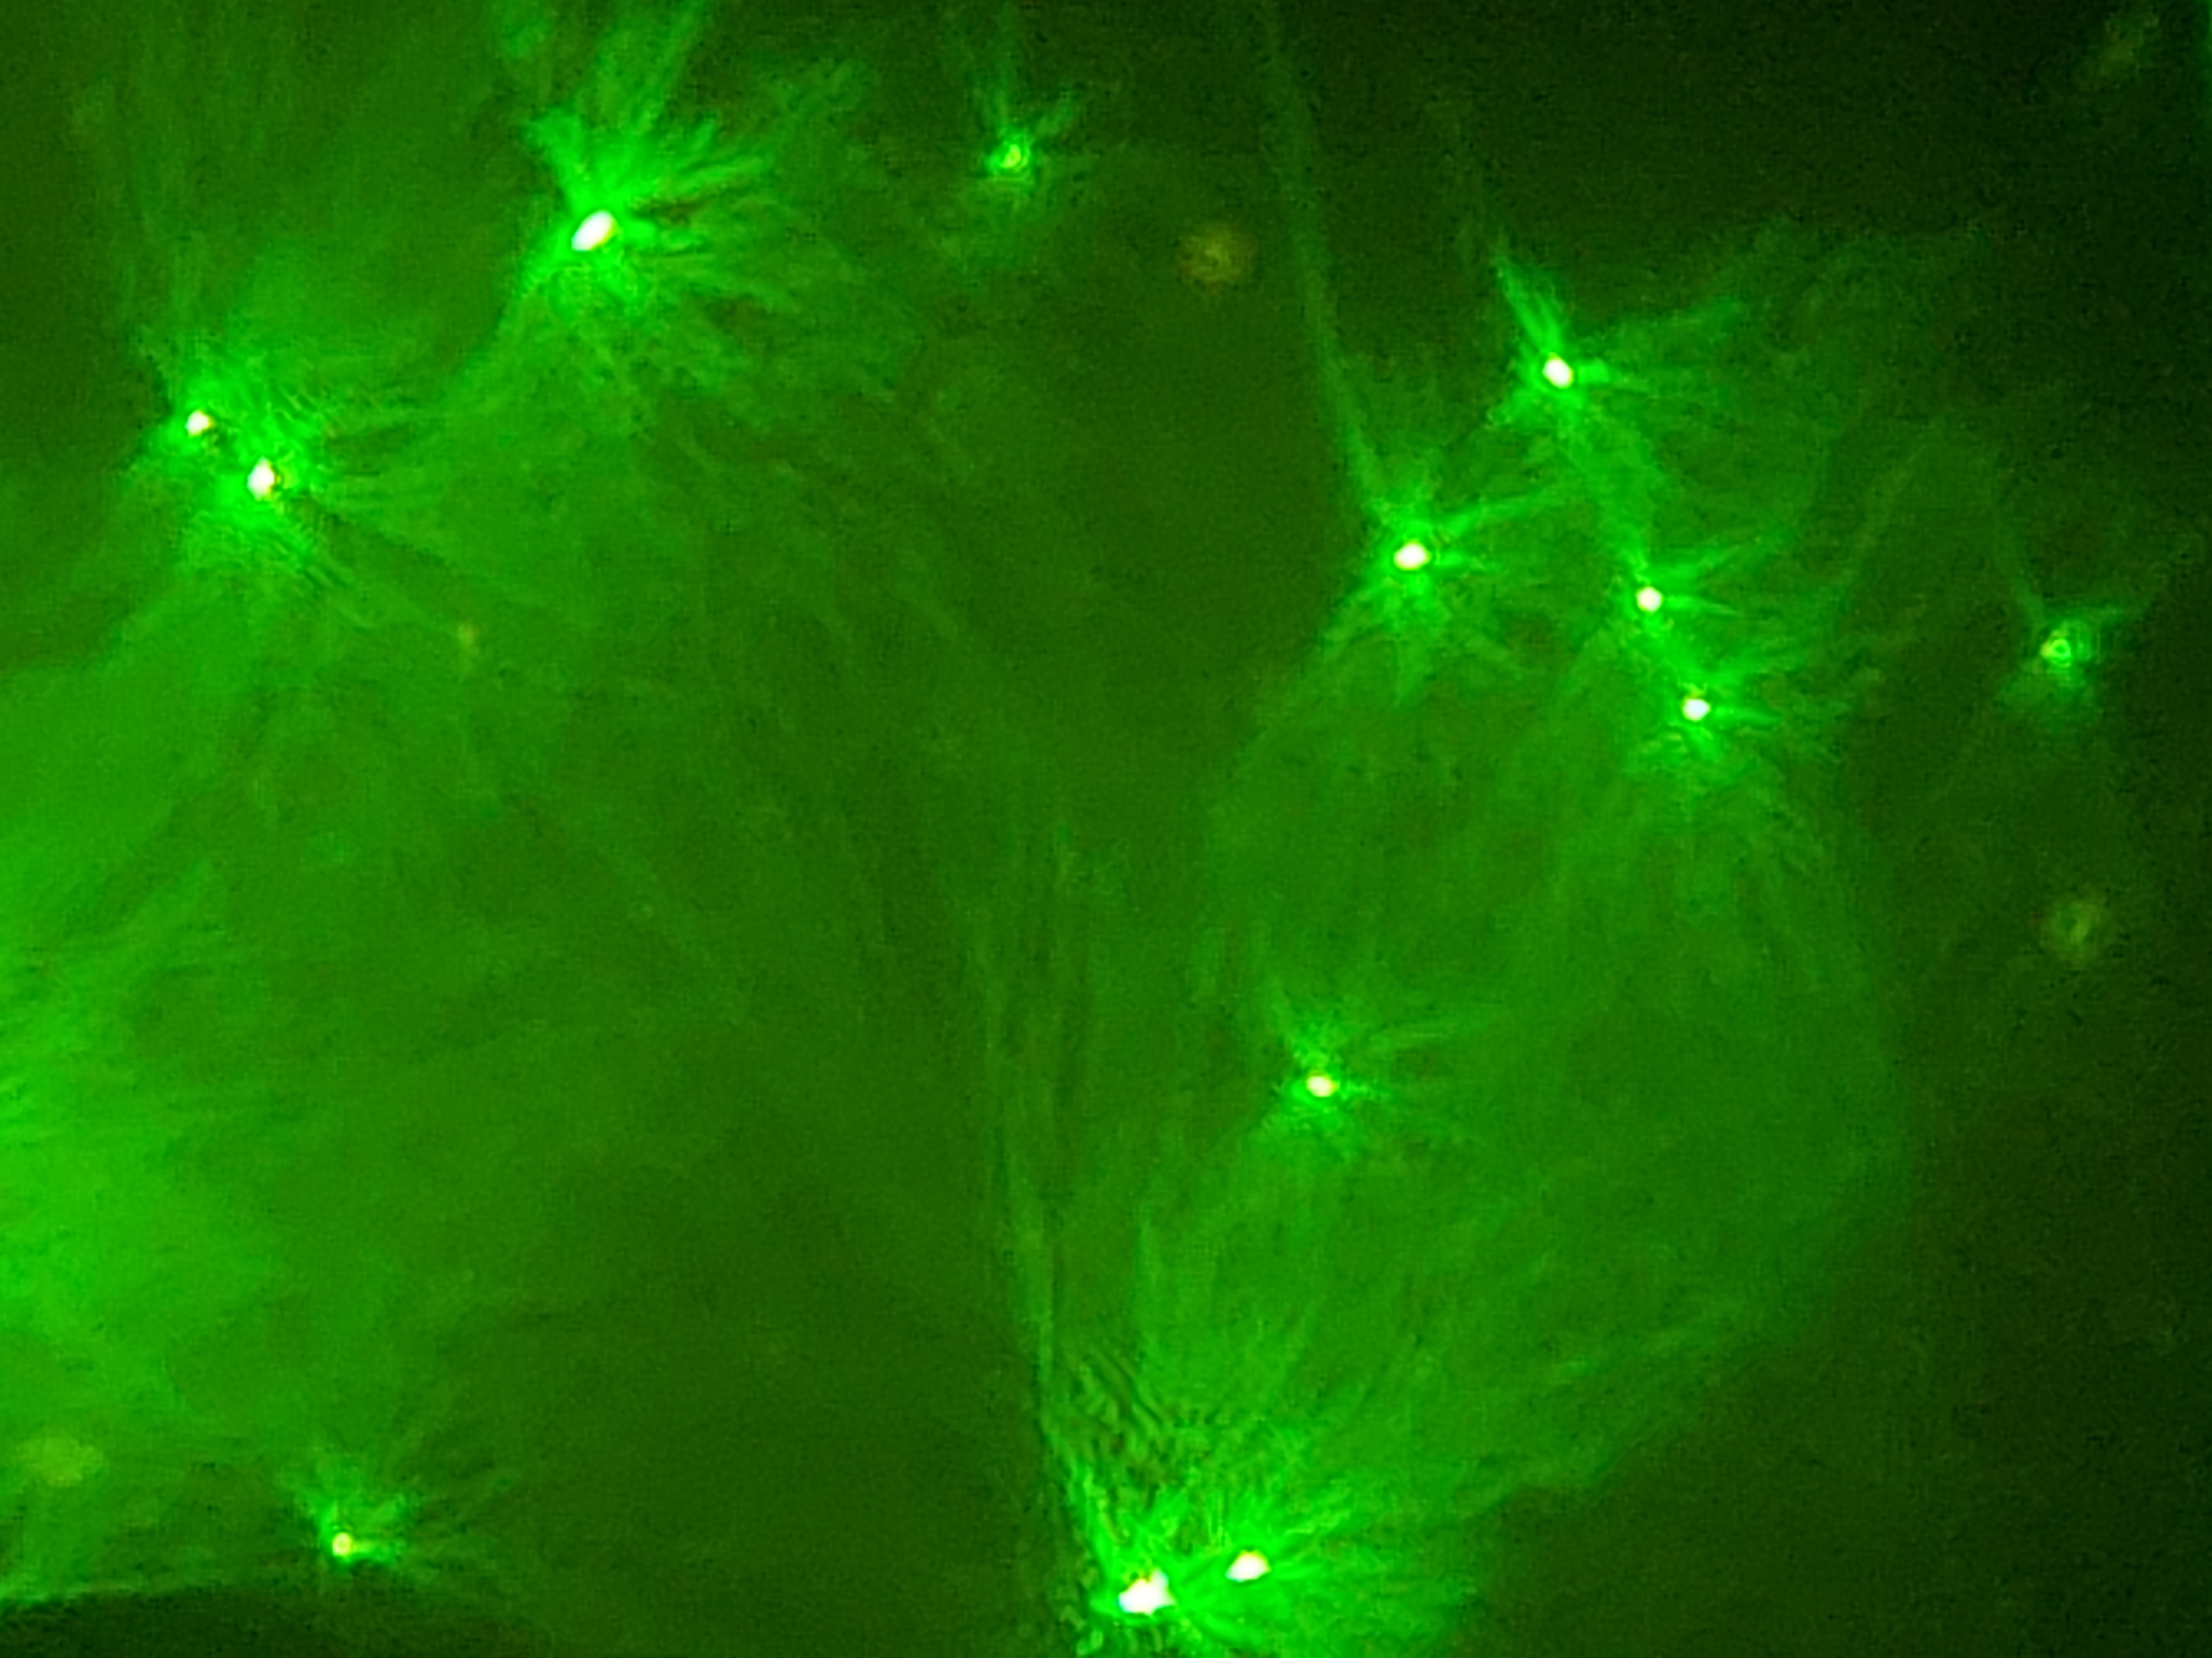

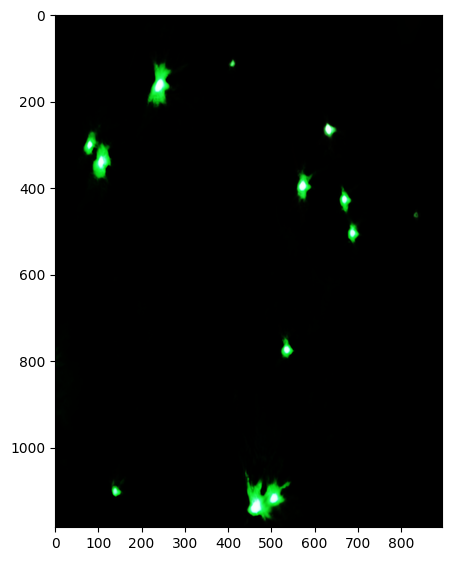

In [ ]:
display(img_test['LR_pil'])
plot_image_grid([new_HR_np], factor=4, nrow=1);

In [ ]:
psnr_new = psnr(test_new_tensor,downsampler(net(test_new_tensor)))
print(psnr_new)

OutOfMemoryError: CUDA out of memory. Tried to allocate 518.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 473.06 MiB is free. Process 12325 has 14.28 GiB memory in use. Of the allocated memory 13.67 GiB is allocated by PyTorch, and 488.52 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import numpy as np
import torch

def calculate_cnr(image, roi_coords, background_coords):
    """
    Calculate the Contrast-to-Noise Ratio (CNR) between a region of interest (ROI) and the background in an image.

    Args:
        image (np.ndarray): The input image as a NumPy array.
        roi_coords (tuple): Coordinates (x, y, width, height) for the ROI.
        background_coords (tuple): Coordinates (x, y, width, height) for the background.

    Returns:
        float: The CNR value.
    """
    # Extract ROI and background regions
    roi_x, roi_y, roi_w, roi_h = roi_coords
    bg_x, bg_y, bg_w, bg_h = background_coords

    roi = image[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]
    background = image[bg_y:bg_y + bg_h, bg_x:bg_x + bg_w]

    # Calculate mean and standard deviation for ROI and background
    mean_roi = np.mean(roi)
    mean_background = np.mean(background)
    std_roi = np.std(roi)
    std_background = np.std(background)

    # Calculate CNR
    cnr = abs(mean_roi - mean_background) / np.sqrt(std_roi**2 + std_background**2)
    return cnr

# Convert tensors to numpy arrays for CNR calculation
original_image_np = torch_to_np(image_tensor)  # Original image tensor to NumPy
improved_image_np = torch_to_np(out_HR)  # Improved image tensor to NumPy

# Define coordinates for ROI and background (adjust based on your specific image)
roi_coords = (50, 50, 100, 100)  # Example ROI: (x, y, width, height)
background_coords = (200, 200, 100, 100)  # Example Background: (x, y, width, height)

# Calculate CNR for original and improved images
cnr_original = calculate_cnr(original_image_np, roi_coords, background_coords)
cnr_improved = calculate_cnr(improved_image_np, roi_coords, background_coords)

print(f"CNR for Original Image: {cnr_original:.2f}")
print(f"CNR for Improved Image: {cnr_improved:.2f}")


NameError: name 'out_HR' is not defined

In [ ]:
import numpy as np
from PIL import Image

def calculate_cnr(image, roi_coords, background_coords):
    """
    Calculate the Contrast-to-Noise Ratio (CNR) between a region of interest (ROI) and the background in an image.

    Args:
        image (np.ndarray): The input image as a NumPy array.
        roi_coords (tuple): Coordinates (x, y, width, height) for the ROI.
        background_coords (tuple): Coordinates (x, y, width, height) for the background.

    Returns:
        float: The CNR value.
    """
    # Extract ROI and background regions
    roi_x, roi_y, roi_w, roi_h = roi_coords
    bg_x, bg_y, bg_w, bg_h = background_coords

    roi = image[roi_y:roi_y + roi_h, roi_x:roi_x + roi_w]
    background = image[bg_y:bg_y + bg_h, bg_x:bg_x + bg_w]

    # Calculate mean and standard deviation for ROI and background
    mean_roi = np.mean(roi)
    mean_background = np.mean(background)
    std_roi = np.std(roi)
    std_background = np.std(background)

    # Calculate CNR
    cnr = abs(mean_roi - mean_background) / np.sqrt(std_roi**2 + std_background**2)
    return cnr

# Load original and improved images
original_image = Image.open('/content/shaky.tif').convert('L')  # Load and convert to grayscale
improved_image = Image.open('/content/Mask_RCNN/final_output_image.png').convert('L')  # Load final output image and convert to grayscale

# Convert images to NumPy arrays
original_image_np = np.array(original_image)
improved_image_np = np.array(improved_image)

# Define coordinates for ROI and background (adjust based on your specific image)
roi_coords = (64, 406, 24, 18)  # Example ROI: (x, y, width, height)
background_coords = (212, 480, 176, 152)  # Example Background: (x, y, width, height)

# Calculate CNR for original and improved images
cnr_original = calculate_cnr(original_image_np, roi_coords, background_coords)
cnr_improved = calculate_cnr(improved_image_np, roi_coords, background_coords)

print(f"CNR for Original Image: {cnr_original:.2f}")
print(f"CNR for Improved Image: {cnr_improved:.2f}")


CNR for Original Image: 2.95
CNR for Improved Image: 4.75
